In [1]:
!pip install -U autoreject

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 14.9 MB/s eta 0:00:00


In [2]:
!pip install mne

In [3]:
import os
import numpy as np
import mne
import json
from AudioOnsetUtils import *

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# set the participant number
PNUM = "14"

In [6]:
RAW_EOG_CHANNELS = [u'EXG1', u'EXG2', u'EXG3', u'EXG4']
MASTOID_CHANNELS = [u'EXG5', u'EXG6']

In [7]:
#path for classification task
data_raw_file = os.path.join("/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/mne/", 'P' + PNUM + '-raw.fif')


# data_raw_file = "/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/mne"
raw = mne.io.read_raw_fif(data_raw_file)

Opening raw data file /content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/mne/P14-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2465433 =      0.000 ...  4815.299 secs
Ready.


In [8]:
# mastoid channel stuff - according to openmirr repo
if MASTOID_CHANNELS[0] in raw.ch_names:
    mne.io.set_eeg_reference(raw.load_data(), MASTOID_CHANNELS, copy=False) # inplace
    raw.drop_channels(MASTOID_CHANNELS)


Reading 0 ... 2465433  =      0.000 ...  4815.299 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.


In [9]:
#Dont run this cell for reconstruction task

# Drop bad channels - in place on raw
for bad_channel in raw.info['bads']:
    # raw.drop_channels(bad_channel)
    print("dropped: " + bad_channel)
print(len(raw.info['bads']))

dropped: T7
dropped: F7
2


In [10]:
print(len(raw.info['bads']))
type(raw.info['bads'])
raw.info['bads'].clear()
len(raw.info['bads'])

2


0

In [11]:
RAW_COPY = raw.copy()

eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])

# bandpass filter - keeping a frequency range between 0.5 (high pass filter) and 30 Hz (low pass filter)
filtered_data = raw.load_data().filter(0.5, 30, picks=eeg_picks)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s


In [12]:
print(filtered_data)

<Raw | P14-raw.fif, 69 x 2465434 (4815.3 s), ~1.27 GB, data loaded>


### RUN BELOW CODE IF ICA NOT GENERATED

In [13]:
# Break raw data into 1 s epochs
tstep = 1.0
events_ica = mne.make_fixed_length_events(filtered_data, duration=tstep)
epochs_ica = mne.Epochs(filtered_data, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

Not setting metadata
4815 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4815 events and 513 original time points ...
0 bad epochs dropped


In [14]:
events_ica.shape


(4815, 3)

In [15]:
from autoreject import get_rejection_threshold

reject = get_rejection_threshold(epochs_ica);
reject

Estimating rejection dictionary for eeg
Estimating rejection dictionary for eog


{'eeg': 0.00013404204837775277, 'eog': 0.0009957486170084073}

In [16]:
# ICA parameters
random_state = 42   # ensures ICA is reproducable each time it's run
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            )
ica.fit(epochs_ica,reject=reject,
        tstep=tstep)

Fitting ICA to data using 64 channels (please be patient, this may take a while)


<ipython-input-16-f980b3aa5950>:9: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica,reject=reject,


Selecting by explained variance: 25 components


KeyboardInterrupt: ignored

In [ ]:
raw.info['ch_names']

['Fp1',
 'AF7',
 'AF3',
 'F1',
 'F3',
 'F5',
 'F7',
 'FT7',
 'FC5',
 'FC3',
 'FC1',
 'C1',
 'C3',
 'C5',
 'T7',
 'TP7',
 'CP5',
 'CP3',
 'CP1',
 'P1',
 'P3',
 'P5',
 'P7',
 'P9',
 'PO7',
 'PO3',
 'O1',
 'Iz',
 'Oz',
 'POz',
 'Pz',
 'CPz',
 'Fpz',
 'Fp2',
 'AF8',
 'AF4',
 'AFz',
 'Fz',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT8',
 'FC6',
 'FC4',
 'FC2',
 'FCz',
 'Cz',
 'C2',
 'C4',
 'C6',
 'T8',
 'TP8',
 'CP6',
 'CP4',
 'CP2',
 'P2',
 'P4',
 'P6',
 'P8',
 'P10',
 'PO8',
 'PO4',
 'O2',
 'EXG1',
 'EXG2',
 'EXG3',
 'EXG4',
 'STI 014']

Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 30.25 Hz)
- Filter length: 5120 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


... filtering target
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 30.25 Hz)
- Filter length: 5120 samples (10.000 s)



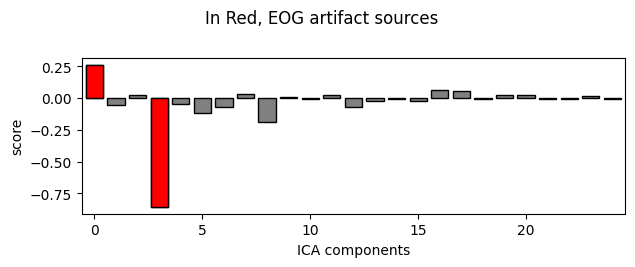

[3, 0]

Using EOG channel: EXG2
... filtering ICA sources
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 30.25 Hz)
- Filter length: 5120 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


... filtering target
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 30.25 Hz)
- Filter length: 5120 samples (10.000 s)



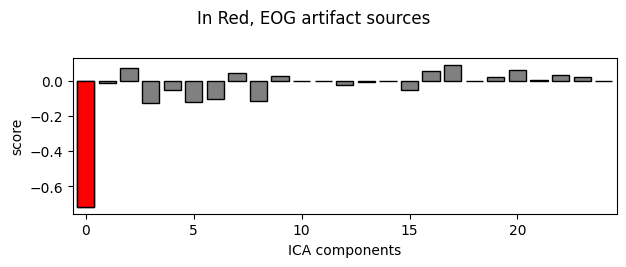

[0]

Using EOG channel: EXG3
... filtering ICA sources
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 30.25 Hz)
- Filter length: 5120 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s


... filtering target
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 30.25 Hz)
- Filter length: 5120 samples (10.000 s)



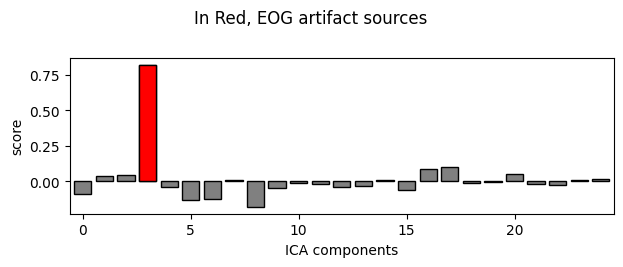

[3]

Using EOG channel: EXG4
... filtering ICA sources
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 30.25 Hz)
- Filter length: 5120 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


... filtering target
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 30.25 Hz)
- Filter length: 5120 samples (10.000 s)



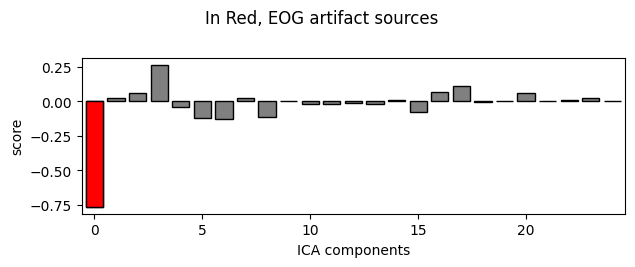

[0]



In [ ]:
bad_comps = set()

for eog_channel in RAW_EOG_CHANNELS:
    bad, scores = ica.find_bads_eog(filtered_data, ch_name=eog_channel, l_freq=0.5, h_freq=30)
    ica.plot_scores(scores, exclude=bad, title='In Red, EOG artifact sources')
    bad_comps.update(bad)
    print(bad)
    print("=========================\n")

In [ ]:
bad_comps

{0, 3}

Using EOG channels: EXG1, EXG2, EXG3, EXG4
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)



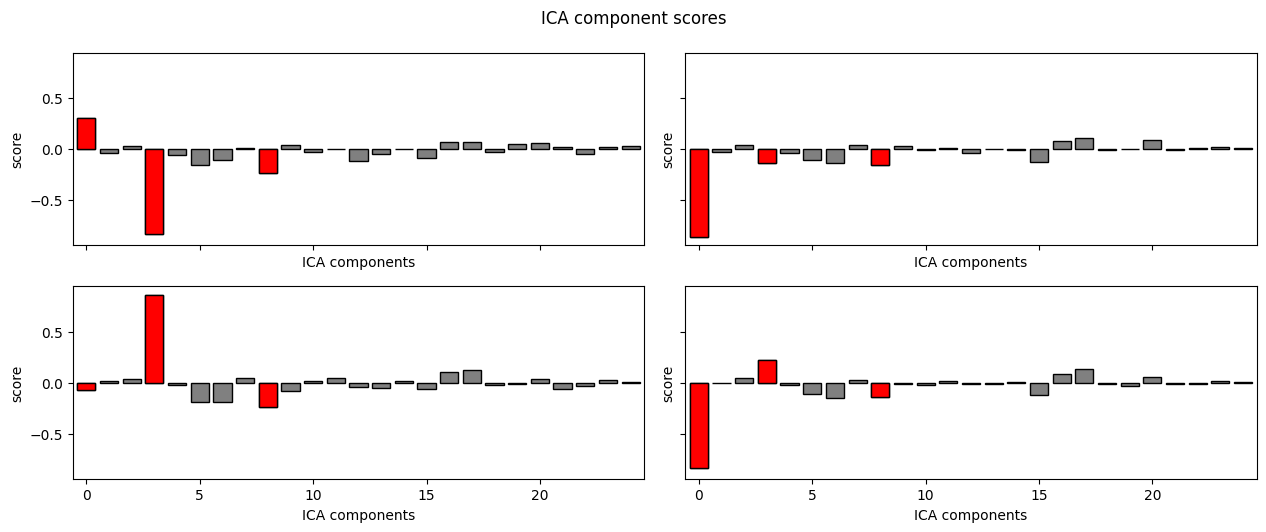

[3, 0, 8]


In [ ]:
ica_z_thresh = 1.96
eog_indices, eog_scores = ica.find_bads_eog(filtered_data,
                                            ch_name=RAW_EOG_CHANNELS,
                                            threshold=ica_z_thresh)
ica.exclude = eog_indices

ica.plot_scores(eog_scores);
print(eog_indices)

In [ ]:
# combine excluded components
ica.exclude.extend(list(bad_comps))
print(list(set(ica.exclude)))

[0, 8, 3]


In [ ]:
# save ICA result for later
#path for reconstruction task
ica.save("/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/64_InputChannels/Sub"+PNUM+'/P' + PNUM + '-ica.fif', overwrite=True)


Overwriting existing file.
Writing ICA solution to /content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/64_InputChannels/Sub14/P14-ica.fif...


Method,fastica
Fit,93 iterations on epochs (2470095 samples)
ICA components,25
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,ICA003ICA000ICA008ICA000ICA003


In [7]:
## This cell gets filtered data so we can open ICA for Participant PNUM

def get_participant_filtered_data(PNUM):
    data_raw_file = os.path.join('/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/mne/', 'P' + PNUM + '-raw.fif')
    raw = mne.io.read_raw_fif(data_raw_file)
    # remove mastoid channels if present
    if MASTOID_CHANNELS[0] in raw.ch_names:
        mne.io.set_eeg_reference(raw.load_data(), MASTOID_CHANNELS, copy=False) # inplace
        raw.drop_channels(MASTOID_CHANNELS)

    # Drop bad channels - in place on raw
    for bad_channel in raw.info['bads']:
        # raw.drop_channels(bad_channel)
         print("dropped: " + bad_channel)
    raw.info['bads'].clear()
    eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])

    # bandpass filter - keeping a frequency range between 0.5 (high pass filter) and 30 Hz (low pass filter)
    filtered_data = raw.load_data().filter(0.5, 30, picks=eeg_picks)
    print('------',raw.info['sfreq'])
    return filtered_data

In [8]:
## This cell opens the ICA file for Participant PNUM

def get_ica_data_from_file(filtered_data, PNUM):
    print("Before reading---?")
    ica = mne.preprocessing.read_ica("/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/64_InputChannels/Sub"+PNUM+'/P' + PNUM + '-ica.fif')
    print("did it read properly?")
    print('----------------------\n')
    print(ica.info['sfreq'])
    # apply the transformation
    postica_data = ica.apply(filtered_data, exclude=ica.exclude)
    return postica_data

In [9]:
# Load the .fif EEG data
filtered_data = get_participant_filtered_data(PNUM)

Opening raw data file /content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/mne/P14-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2465433 =      0.000 ...  4815.299 secs
Ready.
Reading 0 ... 2465433  =      0.000 ...  4815.299 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
dropped: T7
dropped: F7
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequen

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.8s


------ 512.0


In [10]:
sub_ica = get_ica_data_from_file(filtered_data,PNUM)

Before reading---?
Reading /content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/64_InputChannels/Sub14/P14-ica.fif ...
Isotrak not found
Now restoring ICA solution ...
Ready.
did it read properly?
----------------------

512.0
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


In [11]:
sub_ica

<Raw | P14-raw.fif, 69 x 2465434 (4815.3 s), ~1.27 GB, data loaded>

In [12]:
ica_resampled = sub_ica.resample(64)
print(type(ica_resampled))

540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
504 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2000 2001]
<class 'mne.io.fiff.raw.Raw'>


In [13]:
sub_ica

<Raw | P14-raw.fif, 69 x 308179 (4815.3 s), ~162.3 MB, data loaded>

In [14]:
# Extract EEG data and metadata
eeg_data = sub_ica.get_data()
sampling_rate = sub_ica.info['sfreq']
channel_names = sub_ica.info['ch_names']

# Create a dictionary to hold the JSON structure
json_data = {
    "metadata": {
        "sampling_rate": sampling_rate,
        "channels": channel_names,
    },
    "data": eeg_data.tolist()  # Convert NumPy array to nested list
}


In [15]:
print(len(json_data["data"]))
print(type(json_data["data"]))
print(len(json_data["data"][0]))
print(json_data["data"][0][:100])

69
<class 'list'>
308179
[-1.2019875271276093e-05, 1.6211942885327288e-05, 5.196135540887537e-06, 1.0487177701800365e-05, 2.275061062122641e-06, -1.9224004850868145e-06, -8.864968568124472e-07, 3.7949108698754283e-06, -2.687311238447973e-06, -1.2209227877005146e-05, -1.616423028054767e-05, -1.515285075985432e-05, -1.9117724193312885e-05, -2.2417617513884383e-05, -2.2986866269118632e-05, -1.7206813890223105e-05, -1.6287406598525792e-05, -1.1631784099452699e-05, -5.230188121986672e-06, -1.575294724374343e-05, -5.299608436058534e-06, -1.0103816591810056e-06, -9.164150684089503e-06, -7.643272890565393e-06, -9.969149298595943e-06, -9.292244106046061e-06, 3.1271943830657306e-06, -4.790251541602709e-06, -2.6539089143249575e-06, -6.103231784121748e-06, 1.6585793957507524e-06, -8.139146407884161e-07, 1.8191845079018208e-06, 8.004961357969948e-07, 2.8762222361976317e-06, 3.514860072984221e-07, 5.083278401230698e-06, 5.74465479737745e-06, 3.7626044813169045e-06, -7.35569905986843e-06, 7.684190690

In [16]:
## Original code from https://github.com/sstober/openmiir-rl-2016/blob/master/openmiir/events.py#L21 and adapted
KEYSTROKE_BASE_ID = 2000
TIME_INDEX = 0
ID_INDEX = 1

# returns two things, a True if Not Noise boolean and a tuple with three elements:
# 0- this is lyrical (0-2) <- YLABEL
# 1- start time (onsettime + cue duration if condition 1/2, else just onsettime)
# 2- end time (starttime + duration of song without cue)
def get_event_data(event_times_ids, events_index, music_version):
    event_id = event_times_ids[events_index[0]][ID_INDEX]

    if event_id < 1000:
        """
        Event Ids < 1000 are trial labels
        with the last digit indicating the condition
                1 : 'perception',
                2 : 'cued imag',
                3 : 'imag fix cross',
                4 : 'imagination',
        and the remaining digits referring to the stimulus id.
        """
        stimulus_id, condition = decode_event_id(event_id)

        stimulus_info = get_vers_stim_dict(music_version)[stimulus_id]
        cue_length = stimulus_info['cue_length']
        song_length = stimulus_info['song_length']

        events_index[0] += 1

        #print(get_id_to_song_name(stimulus_id))

        # get time of audio onset for this stimulus
        # print('len!!! ---',len(event_times_ids))
        while event_times_ids[events_index[0]][ID_INDEX] != 1000:
            # print("Expected an audio onset event but got {}".format(event_times_ids[events_index[0]]))
          # if events_index[0] >= len(event_times_ids) - 1:
          #   # event_id = event_times_ids[events_index[0]][ID_INDEX]
          #   print("event_id:  ",event_id);
          #   return {
          #     1111: (False, ("noise")),
          #     KEYSTROKE_BASE_ID: (False, 'imagination failed'),
          #     KEYSTROKE_BASE_ID+1: (False, 'imagination okay')
          #   }[event_id]
          # print('events_index[0]: ',events_index[0], " event_times_ids[events_index[0]][ID_INDEX]: ", event_times_ids[events_index[0]][ID_INDEX])
          events_index[0] += 1

        # print('out of while loop\n\n')



        audio_onset_id = event_times_ids[events_index[0]][TIME_INDEX]
        audio_onset_time = sub_ica.times[audio_onset_id]
        start_time = (audio_onset_time + cue_length) if condition in [1,2] else audio_onset_time
        end_time = start_time + song_length

        # move the pointer by 1 to prep next call to get_event_data
        events_index[0] += 1

        return True, (stimulus_info["audio_type"], start_time, end_time, stimulus_id,condition)
    else:
        # move the pointer by 1 to prep next call to get_event_data
        events_index[0] += 1

        return {
            1111: (False, ("noise")),
            KEYSTROKE_BASE_ID: (False, 'imagination failed'),
            KEYSTROKE_BASE_ID+1: (False, 'imagination okay')
        }[event_id]


# convert event id to stimulus (song num) and condition (1-4)
def decode_event_id(event_id):
    if event_id < 1000:
        stimulus_id = event_id // 10
        condition = event_id % 10
        return stimulus_id, condition
    else:
        return event_id

In [17]:
def get_event_data_list(event_times_ids, p):
    events_data_list = []
    events_index = [0]
    music_version = get_participant_vers(p)

    while len(events_data_list) < 100:
        print("len(events_data_list): ",len(events_data_list))
        is_audio, event_data = get_event_data(event_times_ids, events_index, music_version)
        if is_audio:
          events_data_list.append(event_data)

    # print('\n\n Events data list - ')
    # print('len - ', len(events_data_list))
    # for i in events_data_list:
    #   print(i)
    return events_data_list

In [18]:
def get_channels_eeg_data(event_matrix, start_time, end_time, ch_names, postica_data, eeg_event_for_json):
    # for each channel
    # extract this individual event's eeg data btwn start and endtime
    sampling_freq = postica_data.info['sfreq']

    for i in range(len(ch_names)):
        start_stop_seconds = np.array([start_time, end_time])
        start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)

        # returns a tuple, see "extracting data by index" https://mne.tools/dev/auto_tutorials/raw/10_raw_overview.html
        #print(postica_data[i, start_sample:stop_sample])
        ch_selection = postica_data[i, start_sample:stop_sample]
        # print("---------------------------------------")
        # print(ch_selection)
        # print("---------------------------------------")
        # print("type: ",type(ch_selection))
        # print("start sample: ",start_sample)
        # print("stop sample: ",stop_sample)
        # print("len(ch_selection): ",len(ch_selection))
        # print("type ch_selection[0]: ",type(ch_selection[0]))
        # print("len(ch_selection[0]): ",len(ch_selection[0]))
        # print("type ch_selection[0][0]: ",type(ch_selection[0][0]))
        # print("len(ch_selection[0][0]): ",len(ch_selection[0][0]))
        # print("type ch_selection[0][0][0]: ",type(ch_selection[0][0][0]))

        # append eeg data list to eventMatrix, [0].T gets a transpose of the y values of the wave
        event_matrix.append(ch_selection[0].T)
        eeg_event_for_json.append(ch_selection[0].T)

In [19]:
## This cell prepares X_list and Y_list (data and labels)

X_list = []
Y_list = []
monster_matrix = [] # list of matrices

part_list = ["14"]

for part in part_list:
# for part in get_participant_list():
    # load ica data for participant

    # filtered_data = get_participant_filtered_data(part)
    # postica_data = get_ica_data_from_file(filtered_data, part)

    # from ica data, get stimuli events
    events = mne.find_events(sub_ica, shortest_event=1)

    # creates tuples of (event_time, event_id)
    event_times_ids = [(events[:][i][0], events[:][i][2]) for i in range(len(events))]
    # for i in range(len(event_times_ids)):
    #   print(event_times_ids[i][1])

    # get a list of event datas (enum, starttime, endtime)
    events_list = get_event_data_list(event_times_ids, part)

    # for each event in event datas
    event_eeg_dict = {}
    for index , (audio_type,start_time,end_time,stimulus_id,condition) in enumerate(events_list):
        event_matrix = [] # list of lists
        eeg_event_for_json = []
        # get eeg data for all 62 channels, put into event_matrix
        eeg_ch_names = sub_ica.ch_names[:64]
        get_channels_eeg_data(event_matrix, start_time, end_time, eeg_ch_names, sub_ica,eeg_event_for_json)
        # transpose= np.asarray(eeg_event_for_json)
        # transpose = transpose.T
        # eeg_event_for_json = transpose.tolist()
        transpose = [[row[i].item() for row in eeg_event_for_json] for i in range(len(eeg_event_for_json[0]))]
        # converted_transpose = [[x.tolist() for x in sublist] for sublist in transpose]


        print("-------> transpose --------------------")
        # # print(eeg_event_for_json)
        # print("len(eeg_event_for_json): ",len(transpose))
        # print("len(eeg_event_for_json[0]): ",len(transpose[0]))
        # print("type(transpose): ",type(transpose))
        print(transpose)

        event_eeg_dict["e"+str(index)+"_s"+str(stimulus_id)+"_c"+str(condition)] = transpose

        # call normalize on event_matrix


        # append event_matrix to monster_matrix
        monster_matrix.append(event_matrix)

        # 0 for non-lyrical, 1 for lyrical
        # Y_list.append(1) if audio_type == AudioType.LYRICAL else Y_list.append(0)
    # prediction_dir = '/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/preprocessing/ica_json_64Hz/Sub14'
    file_path = "/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/64_InputChannels/Sub"+PNUM+'/P' + PNUM + '.json'
    # os.makedirs(prediction_dir, exist_ok=True)
    with open(file_path, 'w') as file_x:
      json.dump(event_eeg_dict, file_x)


Output hidden; open in https://colab.research.google.com to view.

In [20]:
count = 0
for key,value in event_eeg_dict.items():
  print(len(value))
  count+=1
print("---->count", count)

498
498
497
618
618
618
591
591
573
573
572
783
783
862
861
852
852
852
491
491
744
744
533
533
532
1024
1024
1024
440
1024
1024
1024
744
743
862
862
491
491
533
533
573
573
572
618
618
591
591
498
498
497
440
440
852
852
852
783
783
783
1024
1024
1024
591
591
591
498
498
497
533
532
744
743
862
861
852
852
852
573
618
618
618
491
440
440
744
744
533
532
491
491
498
498
497
862
862
861
591
591
1024
1024
1024
---->count 100


In [21]:
def clipping(no_of_samples, event_matrix):
  return event_matrix[:no_of_samples]

In [22]:
def padding(no_of_samples, event_matrix,mode):
  bottom_padding = no_of_samples-len(event_matrix)
  padded_matrix = np.pad(event_matrix, ((0, bottom_padding), (0, 0)), mode=mode)
  return padded_matrix.tolist()

In [23]:
no_of_samples=618
mode = "symmetric"
padded_clipped_dict={}

In [24]:
for key,value in event_eeg_dict.items():
  if(len(value)<no_of_samples):
    padded_clipped_dict[key]=padding(no_of_samples,value,mode)
  elif(len(value)>no_of_samples):
    padded_clipped_dict[key]=clipping(no_of_samples,value)
  else:
    padded_clipped_dict[key]=value

In [25]:
for key,value in padded_clipped_dict.items():
  print(key," ",len(value)," ",len(value[0]))

e0_s12_c1   618   64
e1_s12_c2   618   64
e2_s12_c3   618   64
e3_s3_c1   618   64
e4_s3_c2   618   64
e5_s3_c3   618   64
e6_s23_c1   618   64
e7_s23_c2   618   64
e8_s13_c1   618   64
e9_s13_c2   618   64
e10_s13_c3   618   64
e11_s14_c1   618   64
e12_s14_c3   618   64
e13_s11_c1   618   64
e14_s11_c3   618   64
e15_s1_c1   618   64
e16_s1_c2   618   64
e17_s1_c3   618   64
e18_s2_c1   618   64
e19_s2_c2   618   64
e20_s4_c1   618   64
e21_s4_c2   618   64
e22_s21_c1   618   64
e23_s21_c2   618   64
e24_s21_c3   618   64
e25_s22_c1   618   64
e26_s22_c2   618   64
e27_s22_c3   618   64
e28_s24_c1   618   64
e29_s22_c1   618   64
e30_s22_c2   618   64
e31_s22_c3   618   64
e32_s4_c1   618   64
e33_s4_c3   618   64
e34_s11_c1   618   64
e35_s11_c2   618   64
e36_s2_c1   618   64
e37_s2_c2   618   64
e38_s21_c1   618   64
e39_s21_c2   618   64
e40_s13_c1   618   64
e41_s13_c2   618   64
e42_s13_c3   618   64
e43_s3_c1   618   64
e44_s3_c3   618   64
e45_s23_c1   618   64
e46_s23_c3   6